In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 데이터 불러오기

In [2]:
DATA_PATH = '../input/plant-pathology-2020-fgvc7/'
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

train.shape, test.shape, submission.shape

((1821, 5), (1821, 1), (1821, 5))

In [3]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [5]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


## 데이터 시각화

In [6]:
# healthy = train.loc[조건식]
healthy = train.loc[train['healthy'] == 1]
multiple_diseases = train.loc[train['multiple_diseases'] == 1]
rust = train.loc[train['rust'] == 1]
scab = train.loc[train['scab'] == 1]

healthy.shape, multiple_diseases.shape, rust.shape, scab.shape


((516, 5), (91, 5), (622, 5), (592, 5))

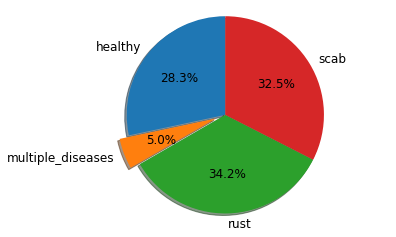

In [7]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rc('font', size = 12)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'healthy', 'multiple_diseases', 'rust', 'scab'
sizes = [516, 91, 622, 592]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

- 이미지 출력

In [8]:
import matplotlib.gridspec as gridspect # 서브플롯 배치
import cv2 # OpenCV 라이브러리

def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows * cols # 이미지가 행/열 갯수보다 많으면 오류 발생
    plt.figure(figsize=(15, 8)) # 전체 Figure 크기 설정
    
    grid = gridspect.GridSpec(rows, cols) # 서브플롯 배치 
    
    # 이미지 출력
    for idx, img_id in enumerate(img_ids):
        img_path = f'{DATA_PATH}/images/{img_id}.jpg' #  이미지 파일 경로 접근
        
        image = cv2.imread(img_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        ax = plt.subplot(grid[idx])
        ax.imshow(image) #  이미지 출력 

- 각 타깃값별 imag_id 6개 

In [9]:
num_of_imgs = 6 
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

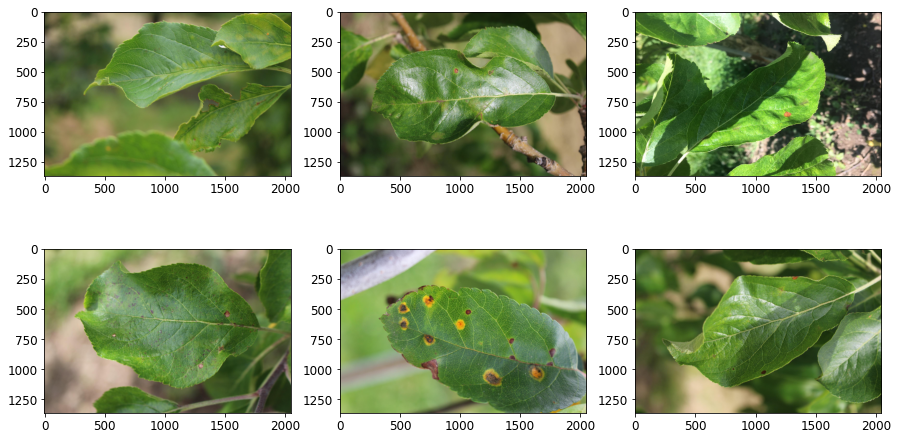

In [10]:
show_image(last_multiple_diseases_img_ids)

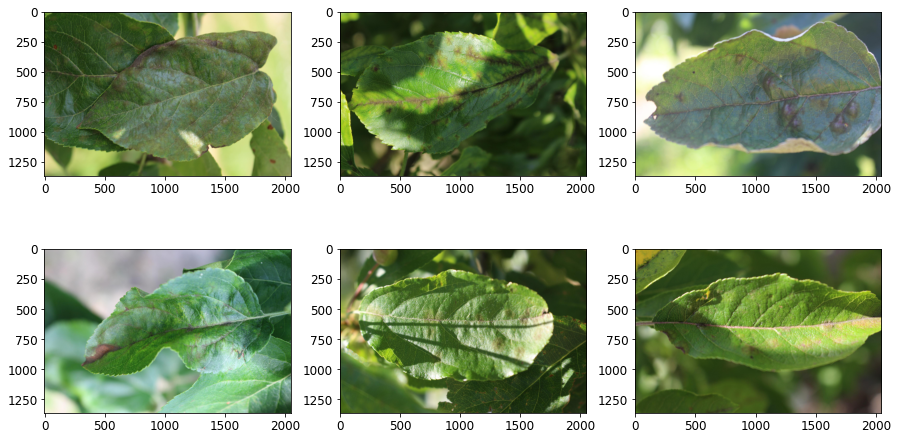

In [11]:
show_image(last_scab_img_ids)

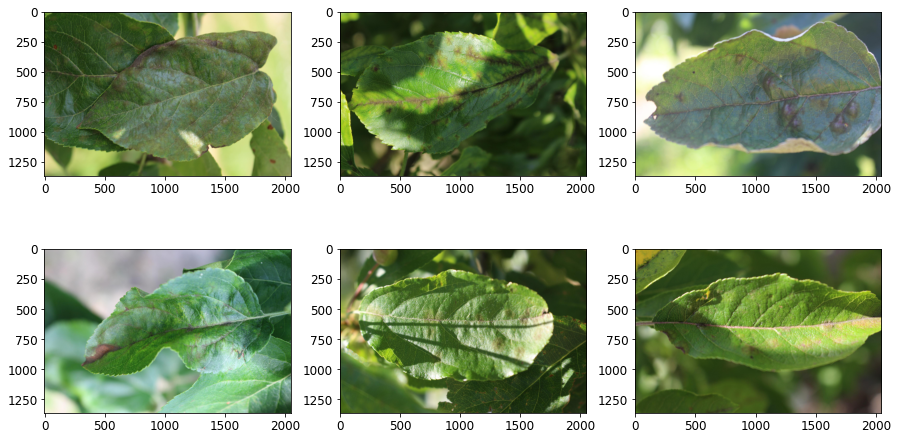

In [12]:
show_image(last_scab_img_ids)

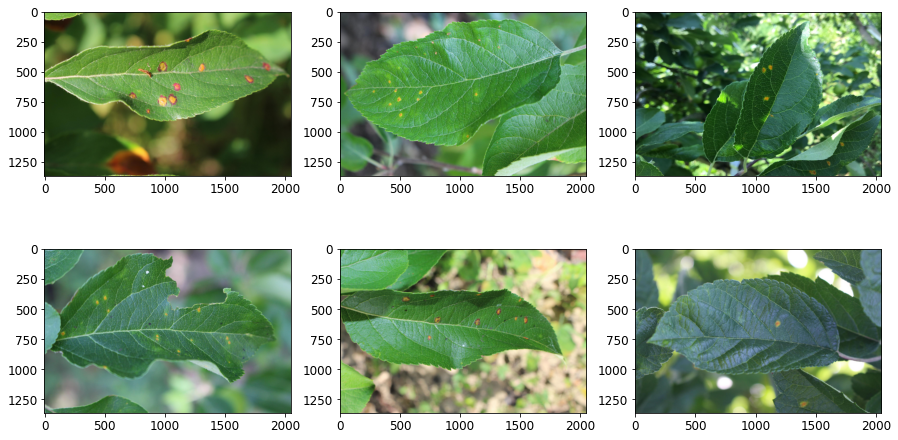

In [13]:
show_image(last_rust_img_ids)

## 파이토치로 모델을 만들어보자.!

- 시드값 및 GPU 설정

In [14]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # CPU
torch.cuda.manual_seed(seed) # GPU
torch.cuda.manual_seed_all(seed) # 다중 GPU
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

- GPU 장비 설정

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

## 데이터넷 분리
- 데이터가 편향적이니깐, 층화추출로 데이터를 분리해야 한다.

In [16]:
from sklearn.model_selection import train_test_split 
train, valid = train_test_split(train, 
                                test_size = 0.1,
                                stratify = train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                                random_state=42)

train.shape, valid.shape

((1638, 5), (183, 5))

## 데이터셋 클래스 정의

In [32]:
import cv2 
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스 
import numpy as np 

class ImageDataset(Dataset):
    
    # 초기화 메서드 
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        
        # 전달받은 인수들 저장 
        self.df = df 
        self.img_dir = img_dir 
        self.transform = transform 
        self.is_test = is_test 
        
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)


    # 각 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id    = self.df.iloc[idx, 0]                    # 이미지 ID
        img_path  = self.img_dir + img_id + '.jpg'          # 이미지 파일 경로
        image     = cv2.imread(img_path)                     # 이미지 파일 읽기
        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 이미지 색상 보정
        
        # 이미지 변환
        if self.transform is not None:    
            # 정의된 데이터 변환 생성 함수 적용
            image = self.transform(image=image)['image']
        
        # 테스트 데이터면 이미지 데이터만 반환, 
        # 훈련데이터면, 이미지 데이터와 타깃밧의 라벨도 같이 반환
        if self.is_test:
            return image # 테스트일 때 
        else:
            # 이미지 + 타깃값 반환
            # 가장 큰 타깃값이 healthy -> 0, ..., rust --> 2, scab --> 3
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label # 훈련 / 검증
            

# 이미지 변환기 정의
- - albumentations : Pytorch에서 주로 사용하는 데이터 증강용 이미지 변환기 라이브러리
    + 참조 : https://github.com/albumentations-team/albumentations

In [18]:
import albumentations as A 
from albumentations.pytorch import ToTensorV2 

print(A.__version__)

# 훈련 데이터용 변환기 
transform_train = A.Compose([
    A.Resize(450, 650),                             # 이미지 크기 조절
    A.RandomBrightnessContrast(brightness_limit = 0.2,       # 밝기 조절 (음수면 어둡게, 양수면 밝게)
                       contrast_limit = 0.2, p=0.3), 
    A.VerticalFlip(p=0.2),                          # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),                        # 좌우 대칭 변환 
    A.ShiftScaleRotate(                             # 이동, 스케일링, 회전 변환
        shift_limit = 0.1, 
        scale_limit = 0.2, 
        rotate_limit = 30, 
        p = 0.3
    ),
    A.OneOf([A.Emboss(p=1),                         # 양각화, Sharpen, 블러링 효과 
             A.Sharpen(p=1), 
             A.Blur(p=1)], p=0.3), 
    A.PiecewiseAffine(p=0.3),                       # 이미지 모양 전체를 변화시킴
    A.Normalize(),                                  # 정규화 변환
    ToTensorV2()                                    # 텐서로 변환 
])

1.3.0


- 테스트 변환기

In [19]:
transform_test = A.Compose([
    A.Resize(450, 650), 
    A.Normalize(), 
    ToTensorV2()
])

## 데이터셋 및 데이터 로더 생성

In [36]:
img_dir = '../input/plant-pathology-2020-fgvc7/images/'
dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)


- 모델 훈련시, 멀티프로세싱을 사용해야 함.

In [37]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

= DateLoader 인스턴스 생성

In [40]:
from torch.utils.data import DataLoader # 데이터 로더 클래스 
batch_size = 4 
loader_train = DataLoader(dataset_train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          worker_init_fn=seed_worker,
                          generator=g, num_workers=2
                         )

loader_valid = DataLoader(dataset_valid, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          worker_init_fn=seed_worker,
                          generator=g, num_workers=2
                         )

In [ ]:
## 모델 생성
- 전이 학습(사전 훈련된 모델)을 사용
- EfficientNet 모델 생성
    + 2019년 5월에 개발된 CNN 모델
- 모델의 정확도를 높일 때, 크게 3가지 필요. (모델의 깊이, 너비, 입력 임지의 크기)
    + 기존 모델은 이 세가지의 모델을 수동으로 조정
    + 위 3가지를 효율적으로 조절할 수 있는 Compound Scaling 방법 확인
    + 깊이, 너비 , 입력 이미지 크기가 어느정도 일정한 관계가 있다. 발견함. ==> 엄청난 사람들.
    

In [41]:
!pip install efficientnet-pytorch==0.7.1


^C
ERROR: Operation cancelled by user


In [28]:
# from efficientnet_pytorch import EfficientNet

- b0 ~ b7까지 있음. 일반적으로 숫자가 높을수록 좋은 모델.
- num_classes 파라미터에는 각 사용자가 최종적으로 출력하고 싶은 갯수 사용
    + num_classes=4
- 파라미터 갯수 미입력, 디폴트 숫자는 1000개를 출력값으로 내보냄,.

In [ ]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5
# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  